# Simulating fly-bys

This notebook will take you through a simulation of fly-bys of a star perturbing a planetary system.

### Imports

In [1]:
import rebound
import numpy as np

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

### Setup
Let's first create a simulation of our target planetary system. We'll use Sun and the outer planets of our solar system for now. Using NASA Horizons database to get the details of each object.

In [2]:
sim = rebound.Simulation()
particle_names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune"]
# we use the NASA horizon database to look up the Sun and planets
sim.add(particle_names)

# let's give all the particles a unique hash (based on its name)
for i, particle in enumerate(sim.particles):
    particle.hash = particle_names[i]

sim.status()
    

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0010311615718129308 y=0.007492167434247096 z=-5.029857654055186e-05 vx=-0.00046735022916381954 vy=9.686988113564261e-05 vz=1.2054876911228158e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-1.8962510303450968 y=-4.98408289062385 z=0.06308803996159881 vx=0.4047327132350172 vy=-0.13506871660296516 vz=-0.008493144781153447>
<rebound.Particle object,

Let's save this simulation for future reference.

In [3]:
sim.save("solar_system_outer_planets.bin")

In [4]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")

Let's define a function that simulates a single fly-by given a certain system and a particle that will be intruding the system.

In [5]:
def simulate_fly_by(sim, intruder, visualize=False):
    intruder.hash = "intruder"
    
    sim.add(intruder)
    
    intruder_distance = np.linalg.norm(sim.particles["intruder"].xyz)
    sim.exit_max_distance = intruder_distance*1.01
    
    while True:
        try:
            sim.integrate(sim.t+5)
            
            if visualize:
                fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]")
                display(fig)
                plt.close(fig)
                clear_output(wait=True)

        except rebound.Escape as error:
            #print(error)
            for i, particle in enumerate(sim.particles):
                distance = np.linalg.norm(particle.xyz)
                if distance > sim.exit_max_distance:
                    #print("Removed", i, str(particle.hash))
                    sim.remove(hash=particle.hash)
                    sim.move_to_com()
                    
            return sim


In [6]:
def calc_escape_velocity(sim, particle):
    #sim.move_to_hel()
    
    r = np.linalg.norm(particle.xyz)
    G = sim.G
    m = sim.particles[0].m
    
    return np.sqrt(2 * G * m / r)

In [7]:
def strong_regime(resolution=100, n_trials=50):
    print("Starting strong regime simulation with resolution {}, {} trials each...".format(resolution, n_trials))
    xs = np.linspace(1, 50, resolution)
    f_eject = np.ones(resolution)
    
    for i, x in enumerate(xs):
        print("Running r_min =", x)
        eject_count = 0.
        
        # run n_trials trials detecting ejection directly after fly-by
        for j in range(n_trials):
            # get a fresh simulation
            sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
            sim = randomize_sim(sim)
            
            intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
            
            sim = simulate_fly_by(sim, intruder)
            
            sim.move_to_hel()
            for particle in sim.particles:
                v = np.linalg.norm(particle.vxyz)
                v_esc = calc_escape_velocity(sim, particle)
                if v > v_esc:
                    eject_count += 1
                    break
        print("Detected", eject_count, "ejections out of", n_trials, "trials.")
        f_eject[i] = eject_count / n_trials
        print(f_eject[i])

    
    return (xs, f_eject)            

In [8]:
# function to check distances, returning 'True' if planets near eachother by mutual Hill radius
from scipy import spatial
import rebound
import numpy as np


def mutual_rhill(p1, p2):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    
    rhill_m = (p1.a + p2.a) / 2. * ((p1.m + p2.m) / 3.)**(1/3.)
    return rhill_m
    

def orbit_list(simulation, period, particle, step_size):
    """
    Creates list of points on an orbit.
    """
    locations = []
    total_time = 0
#     Temporary simulation, adding sun and the particle we want the orbit from
    temp_sim = rebound.Simulation()
    temp_sim.add(simulation.particles[0])
    temp_sim.add(particle)
    particle = temp_sim.particles[1]
#     Integrating over exactly one orbit
    while total_time < period:
        temp_sim.integrate(temp_sim.t+step_size)
        total_time += step_size
        locations.append(particle.xyz)
        
    return np.array(locations)


def check_orbit_crossing(simulation):
    """
    Checks in a simulation whether any orbits cross.
    """
    
#     Creating and saving lists with points on orbits
    locationslist = []
    for i, particle in enumerate(simulation.particles[1:]):
        orbit = particle.calculate_orbit()
        step_size = orbit.P * orbit.rhill / (2 * np.pi * orbit.a)
        locationslist.append(orbit_list(simulation, 
                                        orbit.P, particle, step_size))

#     creating distance matrix
    for i, loc1 in enumerate(locationslist):
        for j, loc2 in enumerate(locationslist[i+1:]): 
            dist_mat = spatial.distance_matrix(loc1, loc2)
            if dist_mat[np.where(dist_mat < mutual_rhill(simulation.particles[i+1], 
                                                         simulation.particles[j+i+2]))].size > 0:
                print(f"Planet {i+1} and {i+j+2} (counting from star) will collide!")
                return True
            
    return False

In [3]:
#orbit = particle.calculate_orbit
#print(orbit)

NameError: name 'particle' is not defined

Let's define a function to predict the stabillity of a system directly after a fly-by.

Instabillity can be defined in a number of ways. The simplest being direct ejection from the system.

This function will try to analyze the stability of a system based on direct observations of it's properties.

In [9]:
def analyze_stability(sim):
    
    if check_immediate_ejection(sim) == True:
        return False
    
    elif check_orbit_crossing(sim) == True:
        return False
    
    elif check_kozai(sim) == True:
        return False
    
    elif check_AMD(sim) == True:
        return False
    
    else:
        return True
    
    
    
    
    

In [10]:
def check_immediate_ejection(sim):
    # move to Sun frame
    sim.move_to_hel()
    
    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            return True
    
    return False
    


In [13]:
xs, f_eject = strong_regime(resolution=30, n_trials=5000)

plt.plot(xs, f_eject)

Starting strong regime simulation with resolution 30, 5000 trials each...
Running r_min = 1.0


/home/starman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


KeyboardInterrupt: 

In [ ]:
plt.plot(xs, 1-f_eject)

In [ ]:
a = np.ones(10)
a[2] = 5
a


In [ ]:
def randomize_sim(sim):
    sim.integrate(np.random.random()*10**3)
    return sim
    

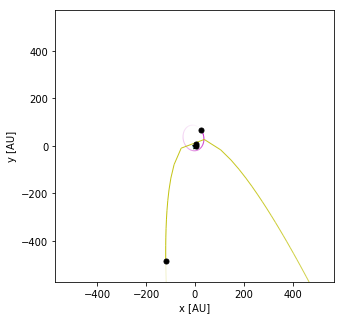

In [ ]:
x = 14.
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.2,x=x,y=-500.,vy=1.35)
simulate_fly_by(sim, intruder, visualize=True)

while sim.t < 10**4:
    evolve_system(sim, 10)
    

#sim.remove(hash="intruder")
#sim.move_to_hel()






In [11]:
def evolve_system(sim, t):
    
    
    sim.exit_max_distance = 500
    
    close_encounters = []
    ejections = []
    # set planet radii to their hill spheres
    for planet in sim.particles[1:]:
        planet.r = planet.rhill
        
    sim.collision = "direct"
    
    end_time = sim.t + t
    while sim.t < end_time:
        try:
            sim.integrate(end_time)
        except (rebound.Collision, rebound.Escape) as error:
            #sim.status()
            if type(error) == type(rebound.Collision()):
                #print(error, sim.t)
                collided = []
                for particle in sim.particles:
                    if particle.lastcollision == sim.t:
                        collided.append(particle.index)
                
                planet_1 = sim.particles[collided[0]]
                planet_2 = sim.particles[collided[1]]
                
                d = np.linalg.norm(np.array(planet_1.xyz) - np.array(planet_2.xyz))
                #print(planet_1.index, planet_2.index, "close encounter. distance:", d)
            
                resolve_collision(sim)
                close_encounters.append(((planet_1.index, planet_2.index), d, sim.t))
            
            else:
                print(error)
                out_of_bounds = []
                for i, particle in enumerate(sim.particles):
                    distance = np.linalg.norm(particle.xyz)
                    if distance > sim.exit_max_distance:
                        #print("Removed", particle.index, str(particle.hash))
                        out_of_bounds.append(particle.hash)
                        ejections.append((particle.index, particle.xyz, sim.t))
                
                for hsh in out_of_bounds:
                        sim.remove(hash=hsh)
                        sim.move_to_com()
                        
        fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]")
        display(fig)
        plt.close(fig)
        clear_output(wait=True)
                        
    return (sim, close_encounters, ejections)

In [12]:
def resolve_collision(sim):
    while True:
        try:
            sim.integrate(sim.t+0.1)
            return
        except:
            #  integrate one step without collision detection
            sim.collision = "none"
            sim.step()
            sim.collision = "direct"
            